# INFO 3950 ps8

name: Kate Li

netid: kl739

In [2]:
import torch, torch.nn as nn, torch.nn.functional as F, numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

## 1)

In [4]:
# read in all the words, I called it ak_names.txt, call it what you like
words = open('names.txt', 'r').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words)))) # 26 characters
stoi = {s:i+1 for i,s in enumerate(chars)}  # string to integer conversion
stoi['.'] = 0  # add in '.' for padding and for end of name
itos = {i:s for s,i in stoi.items()}  # integer back to string
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


He builds a dataset of character n-grams to train on with this function:

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [8]:
#import random
#random.seed(42)
#random.shuffle(words)  #instead use in original order

n1 = int(0.8*len(words)) #80% train
n2 = int(0.9*len(words)) #10% validation / dev

X_train, y_train = build_dataset(words[:n1]) #80%
X_dev, y_dev = build_dataset(words[n1:n2])  #10%
X_test, y_test = build_dataset(words[n2:])  #10%

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


### A. 
The first part of this assignment is to build a model to learn the properties of the training set well enough to generate text from it, starting from this template:

In [10]:
block_size = 3
n_embd = 2
vocab_size = 27
h_layer = 200

model = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(),
    nn.Linear(block_size * n_embd, h_layer),
    nn.ReLU(),
    nn.Linear(h_layer, vocab_size)
)

learning_rate = .001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
batch_size=32
ix = torch.randint(0, len(X_train), (batch_size,))
ix.shape, X_train[ix].shape

(torch.Size([32]), torch.Size([32, 3]))

**i)** Write the code to finish the definition of the model, and train it using 100000 steps of random batch_size=32 chunks, as explained above.

In [13]:
for step in range(100000):
    ix = torch.randint(0, len(X_train), (batch_size,))
    logits = model(X_train[ix])
    loss = loss_fn(logits, y_train[ix])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 5000 == 0:
        print(f"step {step}: training loss = {loss.item():.4f}")

step 0: training loss = 3.2931
step 5000: training loss = 2.3635
step 10000: training loss = 2.2294
step 15000: training loss = 2.1114
step 20000: training loss = 2.2774
step 25000: training loss = 2.1768
step 30000: training loss = 1.8327
step 35000: training loss = 2.3272
step 40000: training loss = 2.0077
step 45000: training loss = 2.5261
step 50000: training loss = 2.1829
step 55000: training loss = 2.3572
step 60000: training loss = 2.2615
step 65000: training loss = 2.1957
step 70000: training loss = 1.9445
step 75000: training loss = 2.1234
step 80000: training loss = 2.2075
step 85000: training loss = 2.1043
step 90000: training loss = 2.3675
step 95000: training loss = 1.9241


In [14]:
logits = model(X_test)
F.cross_entropy(logits, y_test)

tensor(2.4730, grad_fn=<NllLossBackward0>)

**ii)** You can visualize the learned embeddings output from the first layer as below, and since we're not using a random seed in common, your embedding won't look exactly like this one, but should share the feature that it "figures out" that vowels are somehow similar in role and groups them together, and that characters like '.' and 'q' are somehow different from the rest:

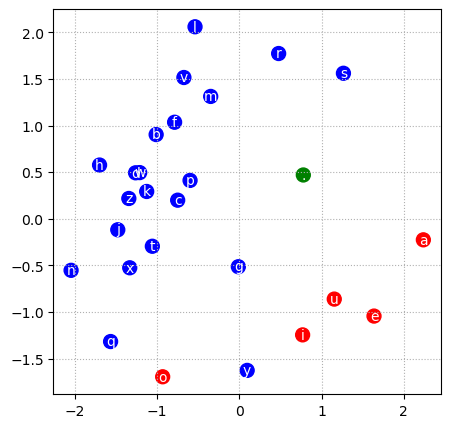

In [16]:
C=model[0](torch.tensor(range(vocab_size)))

vowels = set('aeiou')
alphabet = set('abcdefghijklmnopqrstuvwxyz')
colors = []

for i in range(vocab_size):
    ch = itos[i].lower()
    if ch in vowels:
        colors.append('red')
    elif ch in alphabet:
        colors.append('blue')
    else:
        colors.append('green')


# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(5,5))

plt.scatter(*C.data.T, s=100, c=colors)
for i in range(len(C)):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid(ls=':')

# I figured out how to group the vowels together but I'm not sure how the model figures out that q would be different.
# I think my visualization is still valid and useful though

### B.

In [18]:
for i in range(20):
    context = torch.tensor([[0]*block_size])
    word = []
    generate = True

    while generate:
        probs = F.softmax(model(context), dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1).item()
        word.append(itos[idx_next])
        context = torch.tensor([context[0][1:].tolist() + [idx_next]])

        if idx_next == 0:
            generate = False

    print(''.join(word))

kamya.
ilita.
sary.
bairranton.
khey.
breianya.
avyn.
brean.
sos.
y.
elley.
salon.
arar.
sha.
valixd.
mamym.
warsitti.
mik.
eleenn.
ermier.


### C.
**i.** Now increase the size of the embedding dimension to `n_embd=10`, which should give better performance (`n_embd=2` was just for visualization). The training loss should come down to the $< 2.1$ range.

In [20]:
block_size = 3
n_embd = 10
vocab_size = 27
h_layer = 200

model = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(),
    nn.Linear(block_size * n_embd, h_layer),
    nn.ReLU(),
    nn.Linear(h_layer, vocab_size)
)

learning_rate = .001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
batch_size=32
ix = torch.randint(0, len(X_train), (batch_size,))
ix.shape, X_train[ix].shape

(torch.Size([32]), torch.Size([32, 3]))

In [22]:
for step in range(100000):
    ix = torch.randint(0, len(X_train), (batch_size,))
    logits = model(X_train[ix])
    loss = loss_fn(logits, y_train[ix])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 5000 == 0:
        print(f"step {step}: training loss = {loss.item():.4f}")

step 0: training loss = 3.3188
step 5000: training loss = 1.8888
step 10000: training loss = 1.9710
step 15000: training loss = 2.2075
step 20000: training loss = 1.9699
step 25000: training loss = 1.9506
step 30000: training loss = 2.0816
step 35000: training loss = 2.2773
step 40000: training loss = 1.8244
step 45000: training loss = 1.9464
step 50000: training loss = 1.8387
step 55000: training loss = 1.6438
step 60000: training loss = 2.2155
step 65000: training loss = 2.0160
step 70000: training loss = 1.5859
step 75000: training loss = 2.2948
step 80000: training loss = 2.3725
step 85000: training loss = 1.9479
step 90000: training loss = 2.1164
step 95000: training loss = 2.0295


In [23]:
logits = model(X_test)
F.cross_entropy(logits, y_test)

tensor(2.3810, grad_fn=<NllLossBackward0>)

**ii.** Generate 20 examples. There might be only subtle differences, but see how they compare to the earlier.

In [25]:
for i in range(20):
    context = torch.tensor([[0]*block_size])
    word = []
    generate = True

    while generate:
        probs = F.softmax(model(context), dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1).item()
        word.append(itos[idx_next])
        context = torch.tensor([context[0][1:].tolist() + [idx_next]])

        if idx_next == 0:
            generate = False

    print(''.join(word))

tyse.
khiardani.
emma.
coloyn.
ariah.
holten.
rydorristifh.
alton.
aliamylaytanna.
jordian.
chrikolani.
sha.
milla.
rhelmi.
damaur.
aar.
vika.
avristefa.
madviyah.
braul.


### D.
Train a model with `blocksize=4` (you'll need to generate new training data), and calculate the loss on the training and test sets.  Generate 20 examples -- it might now look more constrained (and less creative), based on predicting from preceding four characters.

In [27]:
block_size = 4

def build_dataset(words):  
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [28]:
n1 = int(0.8*len(words)) #80% train
n2 = int(0.9*len(words)) #10% validation / dev

X_train, y_train = build_dataset(words[:n1]) #80%
X_dev, y_dev = build_dataset(words[n1:n2])  #10%
X_test, y_test = build_dataset(words[n2:])  #10%

torch.Size([182778, 4]) torch.Size([182778])
torch.Size([22633, 4]) torch.Size([22633])
torch.Size([22735, 4]) torch.Size([22735])


In [29]:
block_size = 4
n_embd = 10
vocab_size = 27
h_layer = 200

model = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(),
    nn.Linear(n_embd * block_size, h_layer),
    nn.ReLU(),
    nn.Linear(h_layer, vocab_size)
)
learning_rate = .001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
batch_size=32
ix = torch.randint(0, len(X_train), (batch_size,))
ix.shape, X_train[ix].shape

(torch.Size([32]), torch.Size([32, 4]))

In [31]:
for step in range(100000):
    ix = torch.randint(0, len(X_train), (batch_size,))
    logits = model(X_train[ix])
    loss = loss_fn(logits, y_train[ix])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 5000 == 0:
        print(f"step {step}: training loss = {loss.item():.4f}")

step 0: training loss = 3.4023
step 5000: training loss = 1.9628
step 10000: training loss = 1.8641
step 15000: training loss = 2.3548
step 20000: training loss = 2.2468
step 25000: training loss = 2.2600
step 30000: training loss = 1.9106
step 35000: training loss = 1.8816
step 40000: training loss = 2.2161
step 45000: training loss = 1.8768
step 50000: training loss = 2.1665
step 55000: training loss = 2.1344
step 60000: training loss = 2.1623
step 65000: training loss = 2.1172
step 70000: training loss = 1.9787
step 75000: training loss = 2.1632
step 80000: training loss = 2.1899
step 85000: training loss = 1.7928
step 90000: training loss = 1.9377
step 95000: training loss = 1.6410


In [32]:
logits = model(X_test)
F.cross_entropy(logits, y_test)

tensor(2.3692, grad_fn=<NllLossBackward0>)

In [33]:
for i in range(20):
    context = torch.tensor([[0]*block_size])
    word = []
    generate = True

    while generate:
        probs = F.softmax(model(context), dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1).item()
        word.append(itos[idx_next])
        context = torch.tensor([context[0][1:].tolist() + [idx_next]])

        if idx_next == 0:
            generate = False

    print(''.join(word))

adara.
memmera.
sacha.
syanne.
lealeya.
azana.
lari.
marilynn.
syeve.
aziyah.
hazsofia.
remiah.
farm.
jayde.
malynn.
jemckynnlee.
sabher.
kingsaysha.
zobelani.
nistopheros.


### E.
How many parameters are trained for each of the four models in A, C, D ?

**Model A**

block_size = 3 <br/>
n_embd = 2 <br/>
vocab_size = 27 <br/>
h_layer = 200 <br/>

model = nn.Sequential(

    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(),
    nn.Linear(block_size * n_embd, h_layer),    
    nn.ReLU(),    
    nn.Linear(h_layer, vocab_size)
)

- embedding layer: 27 * 2 = 54 parameters
- linear layer 1: 3 * 2 * 200 + 200 = 1400 parameters
    - bias = 200
- linear layer 2: 200 * 27 + 27 = 5427 parameters
  - bias = 27
- total = 6881 parameters

**Model C**

block_size = 3 <br/>
n_embd = 10 <br/>
vocab_size = 27 <br/>
h_layer = 200 <br/>

model = nn.Sequential(

    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(),
    nn.Linear(block_size * n_embd, h_layer),
    nn.ReLU(),
    nn.Linear(h_layer, vocab_size)
)

- embedding layer: 27 * 10 = 270 parameters
- linear layer 1: 3 * 10 * 200 + 200 = 6200 parameters
    - bias = 200
- linear layer 2: 200 * 27 + 27 = 5427 parameters
    - bias = 27
- total = 11897 parameters

**Model D**

block_size = 4 <br/>
n_embd = 10 <br/>
vocab_size = 27 <br/>
h_layer = 200 <br/>

model = nn.Sequential(

    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(),
    nn.Linear(n_embd * block_size, h_layer),
    nn.ReLU(),
    nn.Linear(h_layer, vocab_size)
)

- embedding layer: 27 * 10 = 270 parameters
- linear layer 1: 10 * 4 * 200 + 200 = 8200 parameters
    - bias = 200
- linear layer 2: 200 * 27 + 27 = 5427 parameters
    - bias = 27
- total = 13897 parameters